In [15]:
!pip install pandas numpy statsmodels linearmodels

In [16]:
import pandas as pd
file_path = "Gov_Responses2Covid19_last.xlsx"
df = pd.read_excel(file_path, sheet_name="Dataset")
df.head()


,country,geoid,iso,d,cases,deaths,school,school_local,domestic,domestic_local,...,wage,credit,taxc,taxd,export,rate,Rigidity_Public_Health,Economic_Measures,population_2019,continent
0,Aruba,AW,ABW,2020-01-01 00:00:00,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,106310.0,America
1,Aruba,AW,ABW,2020-01-02 00:00:00,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,106310.0,America
2,Aruba,AW,ABW,2020-01-03 00:00:00,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,106310.0,America
3,Aruba,AW,ABW,2020-01-04 00:00:00,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,106310.0,America
4,Aruba,AW,ABW,2020-01-05 00:00:00,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,106310.0,America


# Handling Missing Values

In [17]:
# Forward-fill and backward-fill for categorical policy measures within each country
policy_cols = ['school', 'school_local', 'masks', 'masks_partial', 'domestic', 'domestic_local',
               'travel', 'travel_partial', 'travel_dom', 'travel_dom_partial', 'curf', 'curf_partial',
               'mass', 'mass_partial', 'elect', 'elect_partial', 'sport', 'sport_partial', 'rest',
               'rest_local', 'testing', 'testing_narrow', 'surveillance', 'surveillance_partial',
               'state', 'state_partial']

df[policy_cols] = df.groupby(['geoid', 'country'], group_keys=False)[policy_cols].apply(lambda group: group.ffill().bfill())

# Fill remaining missing policy values with 0 (assuming no policy intervention)
df[policy_cols] = df[policy_cols].fillna(0)

# Linear interpolation for economic measures within each country
economic_cols = ['wage', 'taxc', 'credit', 'cash', 'export', 'rate', 'Economic_Measures']
df[economic_cols] = df.groupby(['geoid', 'country'], group_keys=False)[economic_cols].apply(lambda group: group.interpolate(method='linear'))

# Fill remaining missing economic values with 0 (assuming no intervention)
df[economic_cols] = df[economic_cols].fillna(0)

# Rolling average for cases and deaths (7-day window)
df[['cases', 'deaths']] = df.groupby(['geoid', 'country'], group_keys=False)[['cases', 'deaths']].apply(
    lambda group: group.fillna(group.rolling(7, min_periods=1).mean())
)

# Fill remaining missing cases & deaths with 0
df[['cases', 'deaths']] = df[['cases', 'deaths']].fillna(0)

# Drop election-related variables (optional)
df.drop(columns=['elect', 'elect_partial'], errors='ignore', inplace=True)

# Mean imputation for population within the same continent
df['population_2019'] = df.groupby('continent')['population_2019'].transform(lambda x: x.fillna(x.mean()))

# Fill missing continent values using most frequent value (mode)
df['continent'].fillna(df['continent'].mode()[0], inplace=True)

# Fill missing geoid with country ISO code (if applicable)
df['geoid'].fillna(df['iso'], inplace=True)

df['taxd'].fillna(0, inplace=True)
df['Rigidity_Public_Health'].fillna(0, inplace=True)

# Fill remaining missing population with global mean
df['population_2019'].fillna(df['population_2019'].mean(), inplace=True)

# Ensure index alignment
df.reset_index(drop=True, inplace=True)

# Check missing values again
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


<ipython-input-17-38e5698038bb>:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['continent'].fillna(df['continent'].mode()[0], inplace=True)
<ipython-input-17-38e5698038bb>:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

In [18]:
# Check missing values again
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


# Panel Regression

In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
from datetime import datetime, timedelta

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF Values:
                   Variable       VIF
0                     const  2.284648
1    school_intensity_lag42  1.905738
2  domestic_intensity_lag42  3.654628
3     masks_intensity_lag42       inf
4   testing_intensity_lag42       inf
5      mobility_index_lag42  4.179527
6        health_index_lag42       inf
7      economic_index_lag42  1.613649
8      lockdown_masks_lag42  2.123245
Removing high VIF columns: ['masks_intensity_lag42', 'testing_intensity_lag42', 'health_index_lag42']
📌 Impact of Policies on COVID-19 Cases:
                           PanelOLS Estimation Summary                           
Dep. Variable:              log_cases   R-squared:                        0.2197
Estimator:                   PanelOLS   R-squared (Between):              0.2117
No. Observations:               53124   R-squared (Within):               0.2197
Date:                Fri, Mar 21 2025   R-squared (Overall):              0.2149
Time:                        16:50:51   Log-likelihood      

<ipython-input-20-49f360cc5c26>:142: UserWarning: Glyph 129440 (\N{MICROBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129440 (\N{MICROBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129440 (\N{MICROBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


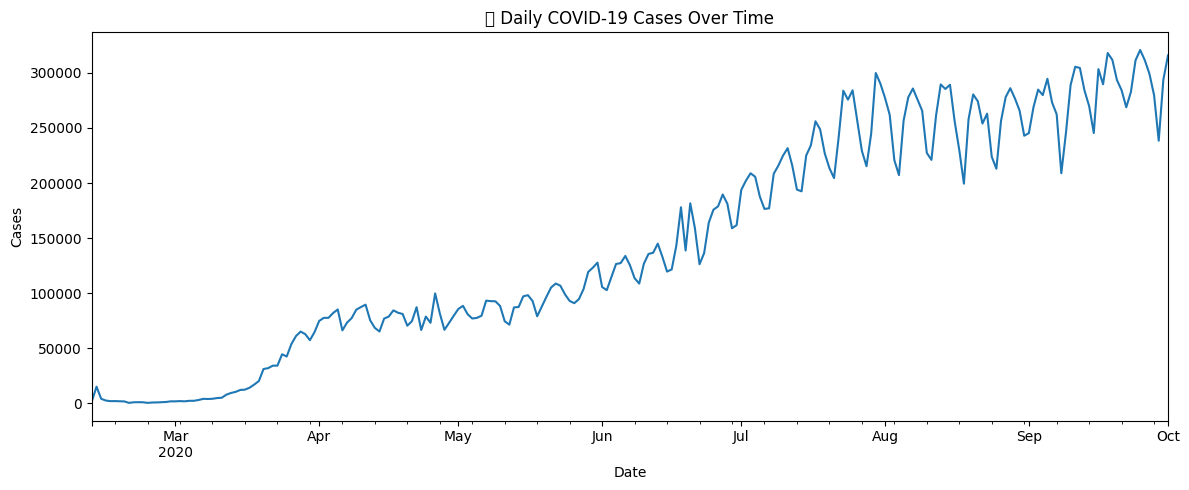

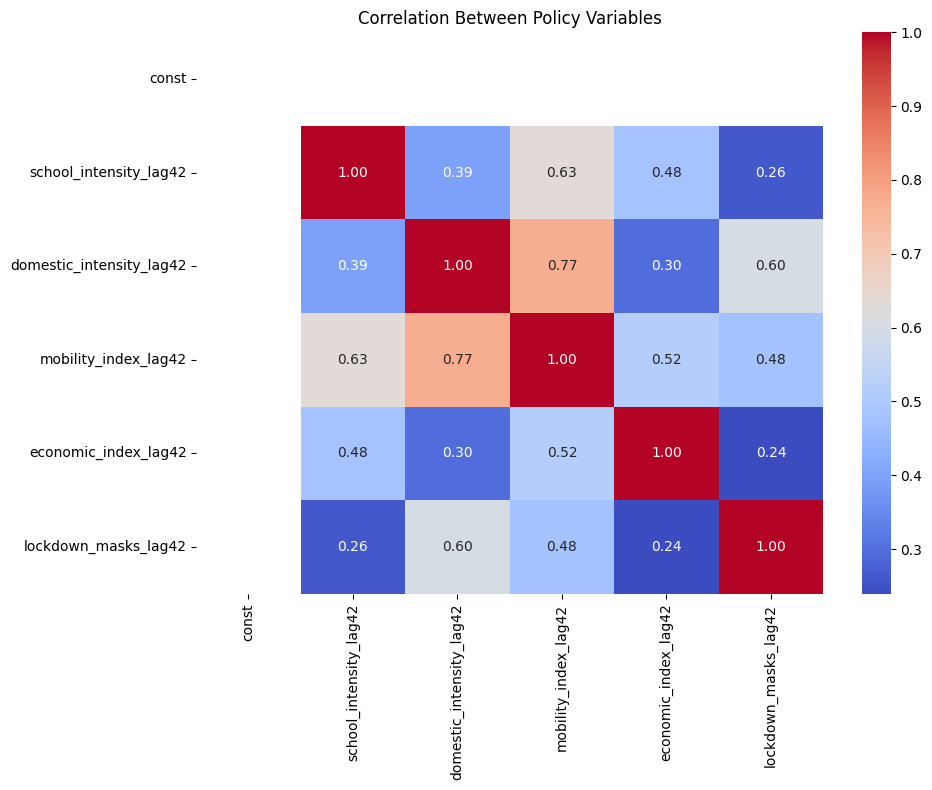

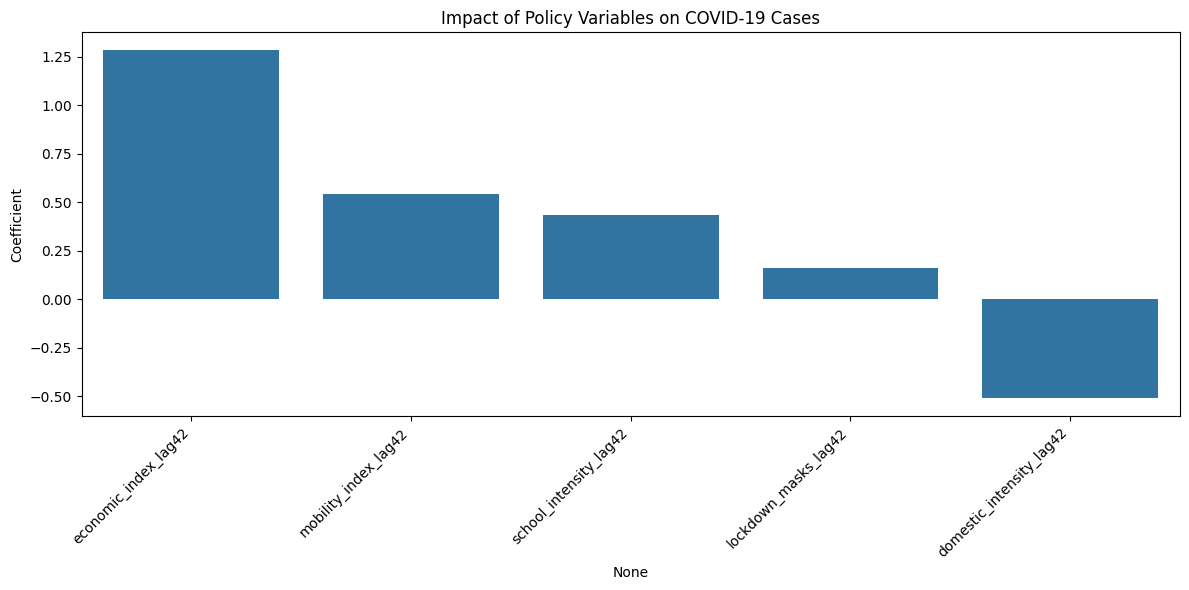

In [ ]:
# ✅ Step 4: Convert Date Column to Datetime Format
df['d'] = pd.to_datetime(df['d'])

# Step 5: Select an expanded set of relevant columns
selected_columns = [
    "cases", "deaths",
    # Basic policy variables
    "school", "domestic", "travel", "travel_dom", "curf", "mass", "sport", "rest",
    "testing", "surveillance", "masks", "state",
    # Partial/local implementation variables
    "school_local", "domestic_local", "travel_partial", "travel_dom_partial",
    "curf_partial", "mass_partial", "sport_partial", "rest_local",
    "testing_narrow", "surveillance_partial", "masks_partial", "state_partial",
    # Economic policy variables
    "cash", "wage", "credit", "taxc", "taxd", "export", "rate",
    # Country and date identifiers
    "country", "d"
]

# Make sure we have a copy, not a view
df = df[selected_columns].copy()

# Handle Missing Values
df.fillna(0, inplace=True)

# Create policy intensity variables properly using .loc
policy_pairs = [
    ("school", "school_local"),
    ("domestic", "domestic_local"),
    ("travel", "travel_partial"),
    ("travel_dom", "travel_dom_partial"),
    ("curf", "curf_partial"),
    ("mass", "mass_partial"),
    ("sport", "sport_partial"),
    ("rest", "rest_local"),
    ("testing", "testing_narrow"),
    ("surveillance", "surveillance_partial"),
    ("masks", "masks_partial"),
    ("state", "state_partial")
]

for base, modifier in policy_pairs:
    # Create intensity variable (0=none, 1=partial/local, 2=national/strict)
    df.loc[:, f"{base}_intensity"] = df[base] * (2 - df[modifier])

# Create policy category groups - choosing a smaller, more focused set
mobility_policies = ["domestic_intensity", "travel_intensity"]
gathering_policies = ["mass_intensity", "sport_intensity"]
health_policies = ["testing_intensity", "masks_intensity"]
economic_policies = ["cash", "wage"]  # Reduced to just two key economic variables

# Create composite policy indices by category
df.loc[:, "mobility_index"] = df[mobility_policies].mean(axis=1)
df.loc[:, "gathering_index"] = df[gathering_policies].mean(axis=1)
df.loc[:, "health_index"] = df[health_policies].mean(axis=1)
df.loc[:, "economic_index"] = df[economic_policies].mean(axis=1)

# Create lag variables for a reduced set of policies to avoid multicollinearity
key_policy_vars = [
    "school_intensity", "domestic_intensity", "travel_intensity",
    "masks_intensity", "testing_intensity",
    "mobility_index", "gathering_index", "health_index", "economic_index"
]

# Create 42-day lags for key policy variables
for policy in key_policy_vars:
    df.loc[:, f"{policy}_lag42"] = df.groupby("country")[policy].shift(42)

# Create just one interaction term to avoid multicollinearity
df.loc[:, "lockdown_masks_lag42"] = df["domestic_intensity_lag42"] * df["masks_intensity_lag42"]

# Drop rows with missing lag values
df.dropna(inplace=True)

# Log Transform Dependent Variables
df.loc[:, "log_cases"] = np.log(df["cases"] + 1)
df.loc[:, "log_deaths"] = np.log(df["deaths"] + 1)

# Set Up Panel Data Structure
df.set_index(["country", "d"], inplace=True)

# Define the Dependent & Independent Variables
y_cases = df["log_cases"]
y_deaths = df["log_deaths"]

# Define a more focused set of independent variables to avoid multicollinearity
X_vars = [f"{policy}_lag42" for policy in [
    "school_intensity", "domestic_intensity", "masks_intensity",
    "testing_intensity", "mobility_index", "health_index", "economic_index"
]] + ["lockdown_masks_lag42"]

X = df[X_vars]
X = sm.add_constant(X)

# Check for multicollinearity before running the model
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("VIF Values:")
print(vif_data)

# Drop highly collinear variables if needed
high_vif_cols = vif_data[vif_data["VIF"] > 10]["Variable"].tolist()
if high_vif_cols:
    print(f"Removing high VIF columns: {high_vif_cols}")
    X = X.drop(columns=high_vif_cols)

# Run panel regression with only entity effects first to avoid rank issues
model_cases = PanelOLS(y_cases, X, entity_effects=True).fit(
    cov_type="clustered", cluster_entity=True)
model_deaths = PanelOLS(y_deaths, X, entity_effects=True).fit(
    cov_type="clustered", cluster_entity=True)

print("📌 Impact of Policies on COVID-19 Cases:\n", model_cases.summary)
print("\n📌 Impact of Policies on COVID-19 Deaths:\n", model_deaths.summary)

# Add time effects only if entity effects model succeeds
try:
    model_cases_both = PanelOLS(y_cases, X, entity_effects=True, time_effects=True).fit(
        cov_type="clustered", cluster_entity=True, check_rank=False)
    model_deaths_both = PanelOLS(y_deaths, X, entity_effects=True, time_effects=True).fit(
        cov_type="clustered", cluster_entity=True, check_rank=False)

    print("\n📌 Impact of Policies on COVID-19 Cases (with time effects):\n", model_cases_both.summary)
    print("\n📌 Impact of Policies on COVID-19 Deaths (with time effects):\n", model_deaths_both.summary)
except Exception as e:
    print(f"Could not run model with both entity and time effects: {e}")

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Plot COVID-19 Cases Over Time
fig, ax = plt.subplots(figsize=(12, 5))
df.reset_index().groupby("d")["cases"].sum().plot(ax=ax)
ax.set_title("🦠 Daily COVID-19 Cases Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Cases")
plt.tight_layout()
plt.show()

# Plot heatmap of policy correlations
plt.figure(figsize=(10, 8))
policy_corr = X.corr()
sns.heatmap(policy_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Policy Variables")
plt.tight_layout()
plt.show()

# Plot coefficients from the model
coef_df = pd.DataFrame({'Coefficient': model_cases.params})
coef_df = coef_df.drop('const', errors='ignore')
coef_df = coef_df.sort_values('Coefficient', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=coef_df.index, y='Coefficient', data=coef_df)
plt.title("Impact of Policy Variables on COVID-19 Cases")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()